## Desk calculator project:

The task is to build a quantum circuit that performs the difference between the binary reprentations
of two positive integers. The circuit can be defined as a variation of the quantum adder explained
in class and using the Quantum Fourier Transform.
The circuit must be implemented in Qiskit and demonstrated on a one or two instances.
The project can be extended with the implementation of a complete desk calculator

## Adder:

In [4]:
# we want to add two positive integer number on a quantum computer
# With the classical computation (on our CPU we have):
a = 1
b = 2

a+b

3

### Toffoli approach

In [5]:
from qiskit import *

In [67]:
# The reason we need numbers with less than 8 digits is because 
#the IBM QISkit simulator only has 32 (qu)bits for us to uses

first = input("Enter a binary number with less than 8 digits")
second = input("Enter another binary number with less than 8 digits")

print(first, second)

Enter a binary number with less than 8 digits110
Enter another binary number with less than 8 digits111
110 111


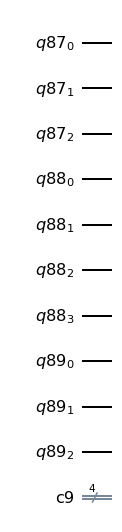

In [68]:
# here we check which number is the longest and we take that length 'l' to declare 
# two quantumRegisters that contain 'l' qubits.
l = len(first)
l2 = len(second)
if l > l2:
     n = l
else:
     n = l2
        
        
#Initializing the registers; two quantum registers with n bits each
#1 more with n+1 bits, which will also hold the sum of the two #numbers
#The classical register has n+1 bits, which is used to make the sum #readable

a = QuantumRegister(n) #First number
b = QuantumRegister(n+1) #Second number, then sum
c = QuantumRegister(n) #Carry bits
cl = ClassicalRegister(n+1) #Classical output
#Combining all of them into one quantum circuit
qc = QuantumCircuit(a, b, c, cl)
qc.draw('mpl')

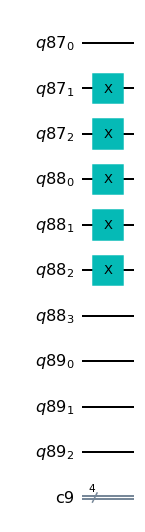

In [69]:
# Setting up the registers using the values inputted
# since the qubits initially always start from 0, we use not gate to set 1 our qubits where in the binary number
# inserted there is a 1
for i in range(l):
    if first[i] == "1":
        qc.x(a[l - (i+1)]) #Flip the qubit from 0 to 1
for i in range(l2):
    if second[i] == "1":
        qc.x(b[l2 - (i+1)]) #Flip the qubit from 0 to 1
qc.draw('mpl')

#note: we ignore the last qbit in b when encoding the second number (eg, using 3 bits, we ignore B3 and we encode on B0 B1 B2)

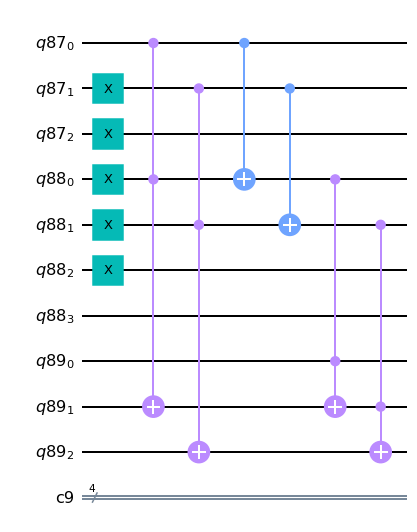

In [70]:
#Implementing a carry gate that is applied on all (c[i], a[i], b[i]) #with output fed to c[i+1]
for i in range(n-1):
    qc.ccx(a[i], b[i], c[i+1]) #and di carry
    qc.cx(a[i], b[i]) # xor di somma
    qc.ccx(c[i], b[i], c[i+1]) #visto che c[i+1] = 0 sempre, questo è un and tra C e B
    #è un and per verificare il carry: infatti se al passaggio precedente è stato assegnato un carry = 1 a questo indice, 
    #e se b = 1, allora si 'sfora' (1+1 = 0 con carry di 1) e si dà il carry al bit dopo

qc.draw('mpl')

#and qc.ccx(a[i], b[i], c[i]) if c=0 and a=1 and b=1 then it is an AND gate

#sum = (a xor b) xor cin
#cout = a and b or cin (a xor b)

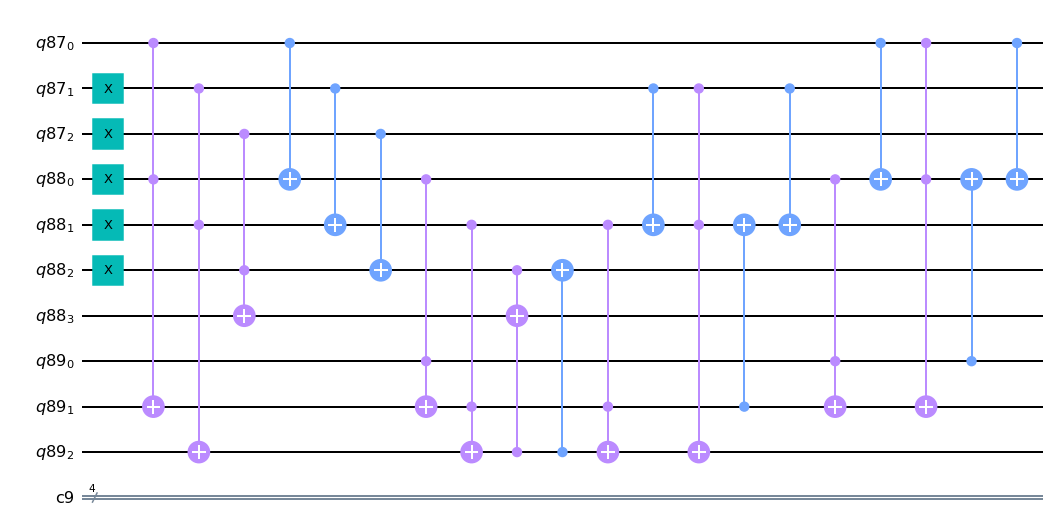

In [71]:
#sum = (a xor b) xor cin
#cout = a and b or cin (a xor b)

#For the last iteration of the carry gate, instead of feeding the
#result to c[n], we use b[n], which is why c has only n bits,
#with c[n-1] being the last carry bit
qc.ccx(a[n-1], b[n-1], b[n])
qc.cx(a[n-1], b[n-1])
qc.ccx(c[n-1], b[n-1], b[n])


#Reversing the gate operation performed on b[n-1]
qc.cx(c[n-1], b[n-1])
#se l'ultimo bit di c è uguale a 1, allora flippa l'ultimo bit di b
#lo facciamo solo per l'ultimo bit visto che se c'è un riporto si deve


#Reversing the gate operations performed during the carry gate
#implementations, which is done to reset all carry bits to 
#the |0> state
for i in range(n-1):
    qc.ccx(c[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
    qc.cx(a[(n-2)-i], b[(n-2)-i])
    qc.ccx(a[(n-2)-i], b[(n-2)-i], c[(n-1)-i])
    
    #These two operations act as a sum gate; if a control bit is 
    #in the |1> state then the target bit b[(n-2)-i] is flipped
    qc.cx(c[(n-2)-i], b[(n-2)-i])
    qc.cx(a[(n-2)-i], b[(n-2)-i])

qc.draw('mpl')


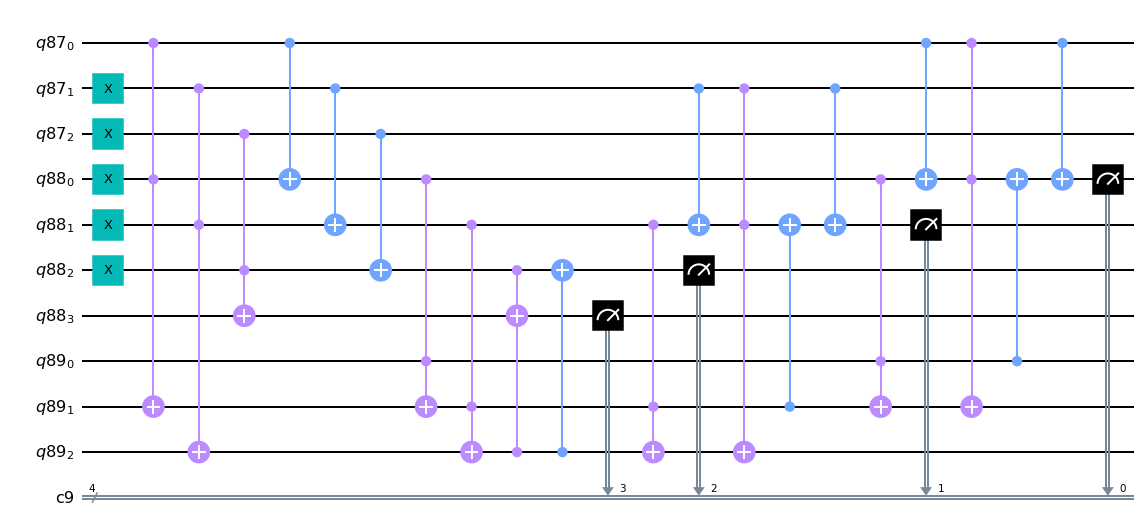

In [72]:
#Measure qubits
for i in range(n+1):
    qc.measure(b[i], cl[i])
    
qc.draw('mpl')

In [73]:
#Set chosen backend and execute job
num_shots = 100 #Setting the number of times to repeat measurement
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats) 

{'1101': 100}



# half adder di qiskit



In [3]:
from qiskit import *

In [5]:
first = input("Enter a binary number with less than 8 digits")
second = input("Enter another binary number with less than 8 digits")

print(first, second)

Enter a binary number with less than 8 digits110
Enter another binary number with less than 8 digits011
110 011


In [ ]:
# here we check which number is the longest and we take that length 'l' to declare 
# two quantumRegisters that contain 'l' qubits.
l = len(first)
l2 = len(second)
if l > l2:
     n = l
else:
     n = l2
        
#teniamo in n la lunghezza del num + lungo
        
#Initializing the registers; two quantum registers with n bits each
#1 more with n+1 bits, which will also hold the sum of the two #numbers
#The classical register has n+1 bits, which is used to make the sum #readable

a = QuantumRegister(n) #First number
b = QuantumRegister(n) #Second number
c = QuantumRegister(n) #Carry bits
supp = QuantumRegister(3) #support bit
ris = QuantumRegister(n+1) #Result bits
cl = ClassicalRegister(n+1) #Classical output
#Combining all of them into one quantum circuit
qc = QuantumCircuit(a, b, c, supp, ris, cl)
qc.draw('mpl')

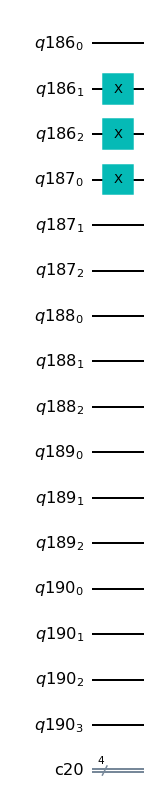

In [127]:
# Setting up the registers using the values inputted
# since the qubits initially always start from 0, we use not gate to set 1 our qubits where in the binary number
# inserted there is a 1
for i in range(l):
    if first[i] == "1":
        qc.x(a[l - (i+1)]) #Flip the qubit from 0 to 1
for i in range(l2):
    if second[i] == "1":
        qc.x(b[l2 - (i+1)]) #Flip the qubit from 0 to 1
qc.draw('mpl')

#half adder

#SUM
# use cnots to write the XOR of the inputs on qubit 2
qc.cx(a[0], ris[0])
qc.cx(b[0], ris[0])
#stiamo facendo lo xor su a e ris o su b e ris: se a o b = 1 allora flippa il risultato, 
#se entrambi a e b sono = 1 allora si flippa 2 volte che è come se non fosse mai stato flippato

#CARRY
# use ccx to write the AND of the inputs on qubit 3
qc.ccx(a[0],b[0],c[0])
#usiamo toffoli: se sia a che b sono  = 1 allora metti il carry a 1

# extract outputs
qc.measure(ris[0], cl[0]) # extract XOR value
qc.measure(c[0], cl[1]) # extract AND value non è da stampare davvero, si passa poi all'half adder successivo

qc.draw('mpl')

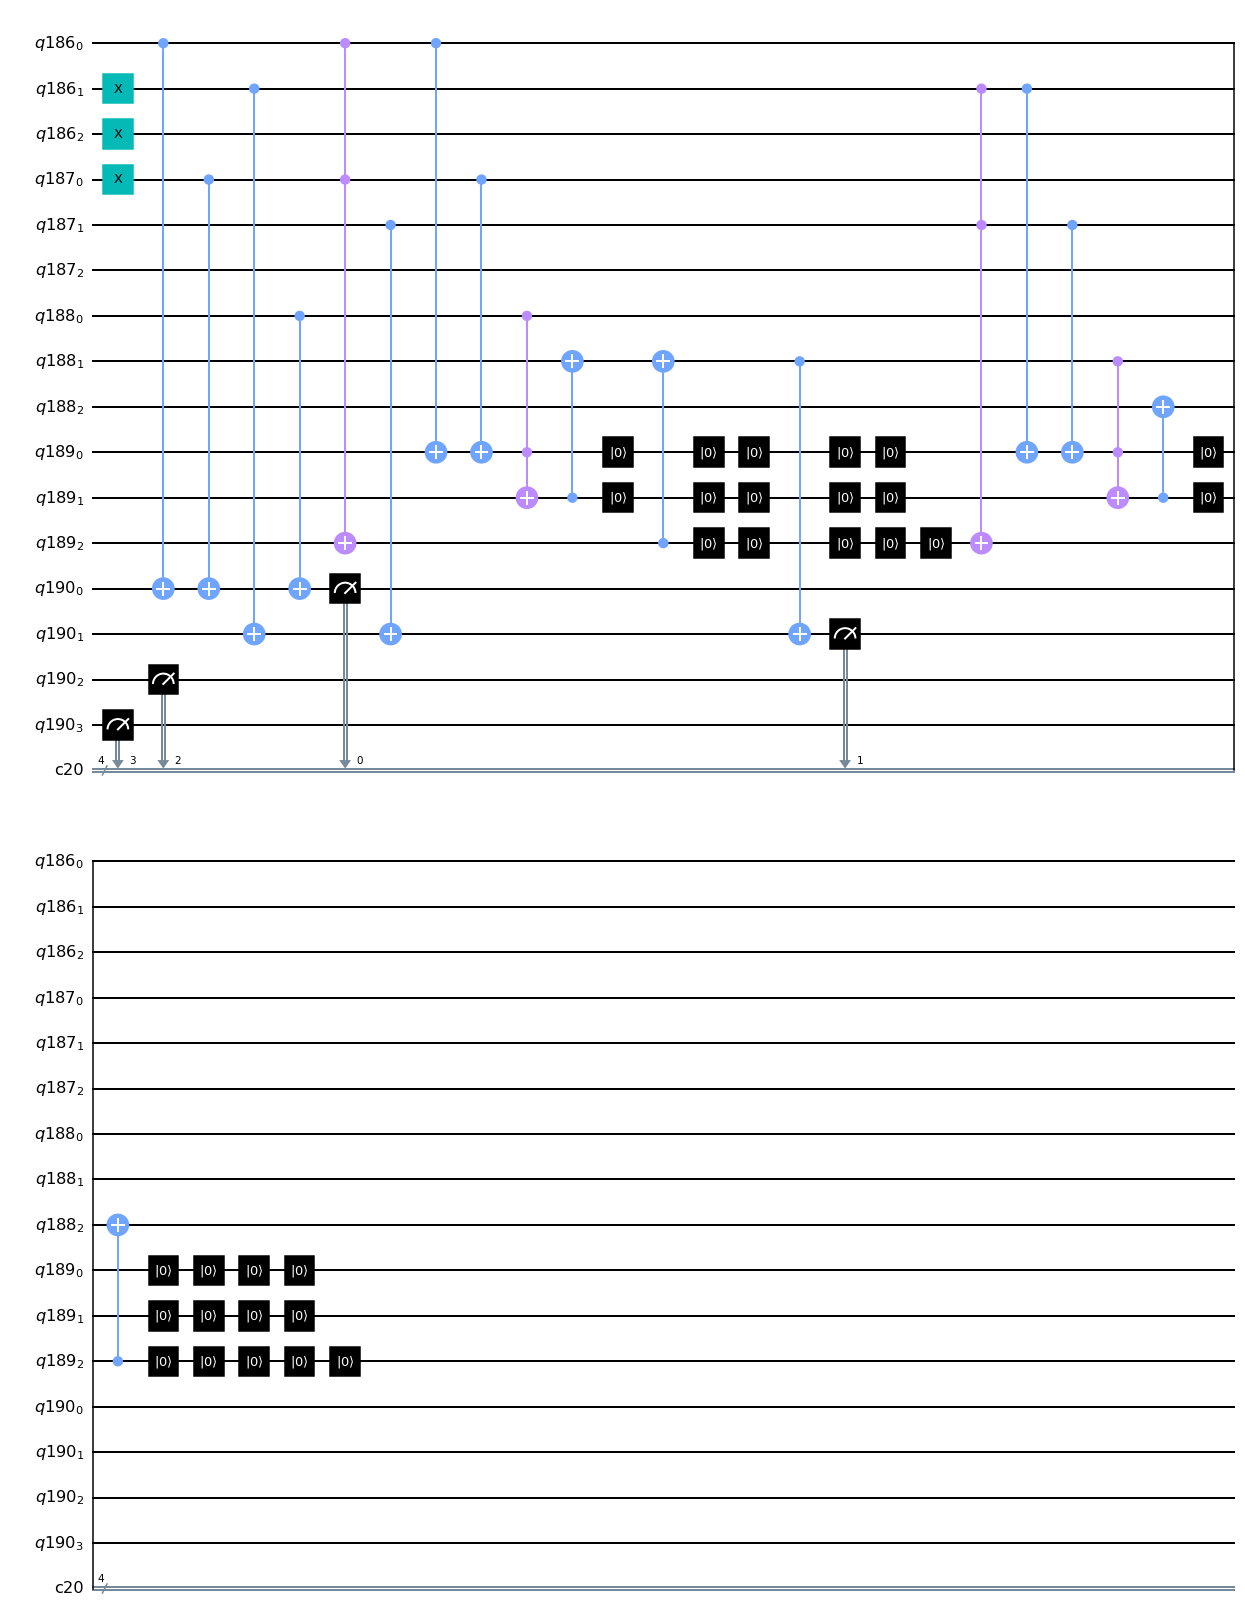

In [128]:
#ripple adder test

#sum = (a xor b) xor cin
#cout = (a and b) OR ((a xor b) and cin)
#nel cout al posto dell'OR posso usare lo XOR!!!! non saranno mai i due and uguali a 1!!!

for i in range(n-1):
    #SUM
    #sum = (a xor b) xor cin
    # use cnots to write the XOR of the inputs on qubit 2
    qc.cx(a[i], ris[i])
    qc.cx(b[i], ris[i])
    
    qc.cx(c[i], ris[i]) #??
    #stiamo facendo lo xor su a e ris o su b e ris: se a o b = 1 allora flippa il risultato, 
    #se entrambi a e b sono = 1 allora si flippa 2 volte che è come se non fosse mai stato flippato

    #CARRY
    #cout = (a and b) XOR ((a xor b) and cin)
    #cout = i+1
    #cin = i
    # use ccx to write the AND of the inputs on qubit 3
    qc.ccx(a[i],b[i],supp[2])
    
    qc.cx(a[i], supp[0])
    qc.cx(b[i], supp[0])
    
    qc.ccx(supp[0], c[i], supp[1])
    
    qc.cx(supp[1], c[i+1])
    qc.cx(supp[2], c[i+1])  
    
    #reset to 0 supp
    qc.reset([9]*5)
    qc.reset([10]*5)
    qc.reset([11]*5)

#SUM
#sum = (a xor b) xor cin
qc.cx(a[n-1], ris[n-1])
qc.cx(b[n-1], ris[n-1])

qc.cx(c[n-1], ris[n-1])

#CARRY
#cout = (a and b) XOR ((a xor b) and cin)
#cout = i+1
#cin = i
# use ccx to write the AND of the inputs on qubit 3
qc.ccx(a[n-1],b[n-1],supp[2])

qc.cx(a[n-1], supp[0])
qc.cx(b[n-1], supp[0])

qc.ccx(supp[0], c[n-1], supp[1])

#note: instead of saving the last cout in the c qubit, we store it in the last digit of the result (hence the longer ris + 1)
qc.cx(supp[1], ris[n])
qc.cx(supp[2], ris[n])  

#reset to 0 supp
qc.reset([9]*5)
qc.reset([10]*5)
qc.reset([11]*5)

    
for i in range(n+1):
    qc.measure(ris[i], cl[i])
    
qc.draw('mpl')

In [129]:
#Set chosen backend and execute job
num_shots = 100 #Setting the number of times to repeat measurement
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=num_shots)
#Get results of program
job_stats = job.result().get_counts()
print(job_stats) 

{'0011': 100}
